<a href="https://colab.research.google.com/github/Mehedi16009/F1Tenth-MC-Scheduling/blob/main/Physics_Informed_MC_Scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Mixed-Criticality Scheduling (Colab reproduction)
**Goals:** replicate the RTAS 2025 idea: a preemptive EDF ROS-like executor with environment-driven mode switches applied to an F1Tenth-style 2D simulation.

This notebook contains:
- an event-driven **preemptive EDF scheduler** (mode switching: LOW ↔ HIGH),
- a **2D corridor track** and simple LiDAR raycast,
- **pure pursuit** (centerline) + **follow-the-gap** controllers,
- physics integration and scheduler-controller coupling,
- visualizations (Gantt scheduling chart, car trajectory),
- Monte-Carlo trials to estimate crash probability (with & without mode switching).

**Implementation notes:** The code uses ms units inside the scheduler (integers) and seconds for physics integration. It is tuned to be runnable in Google Colab (no ROS2 / UPPAAL required).


In [1]:
# @title Cell 1: Imports and small helpers
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass, field
import copy
import time

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Small helper: convert ms to seconds
def ms2s(ms):
    return ms / 1000.0

def s2ms(s):
    return int(round(s * 1000))

# Pretty colors for tasks (consistent across plots)
TASK_COLORS = {
    'Driver': '#1f77b4',
    'Health': '#ff7f0e',
    'Dummy0': '#2ca02c',
    'Dummy1': '#d62728',
}


In [2]:
# @title Cell 2: Simulation parameters & task definitions (based on Table I in paper)
# We'll represent task compute times and periods in milliseconds.

@dataclass
class TaskSpec:
    name: str
    C: int         # worst-case execution time (ms)
    T_lo: int      # period in low mode (ms)
    T_hi: int | None  # period in high mode (ms) or None if dropped
    chi: int       # criticality flag: 1 -> remain in high mode, 0 -> dropped in high

# Table I-like taskset (values from the paper)
TASK_SPECS = [
    TaskSpec('Driver',  C=15, T_lo=100, T_hi=25, chi=1),
    TaskSpec('Health',  C=1,  T_lo=25,  T_hi=25, chi=1),
    TaskSpec('Dummy0',  C=21, T_lo=40,  T_hi=80, chi=1),  # in paper Dummy0 has chi=1
    TaskSpec('Dummy1',  C=8,  T_lo=30,  T_hi=None, chi=0), # dropped in high
]

# Reaction-time requirement from paper example for verification experiments (ms)
REQUIRED_REACTION_TIME_MS = 45  # paper's example number

# Simulation overall parameters
EPISODE_DURATION_MS = 20_000   # 20 seconds per episode
PHYSICS_DT_MS = 10             # physics integration timestep (10 ms)
LIDAR_MAX_RANGE = 5.0          # meters
LIDAR_NUM_RAYS = 181           # -90..+90 deg
CAR_RADIUS = 0.07              # approximate car radius (m)
WHEELBASE = 0.18               # bicycle model wheelbase (m)
DEFAULT_SPEED = 1.2            # m/s (nominal forward speed)


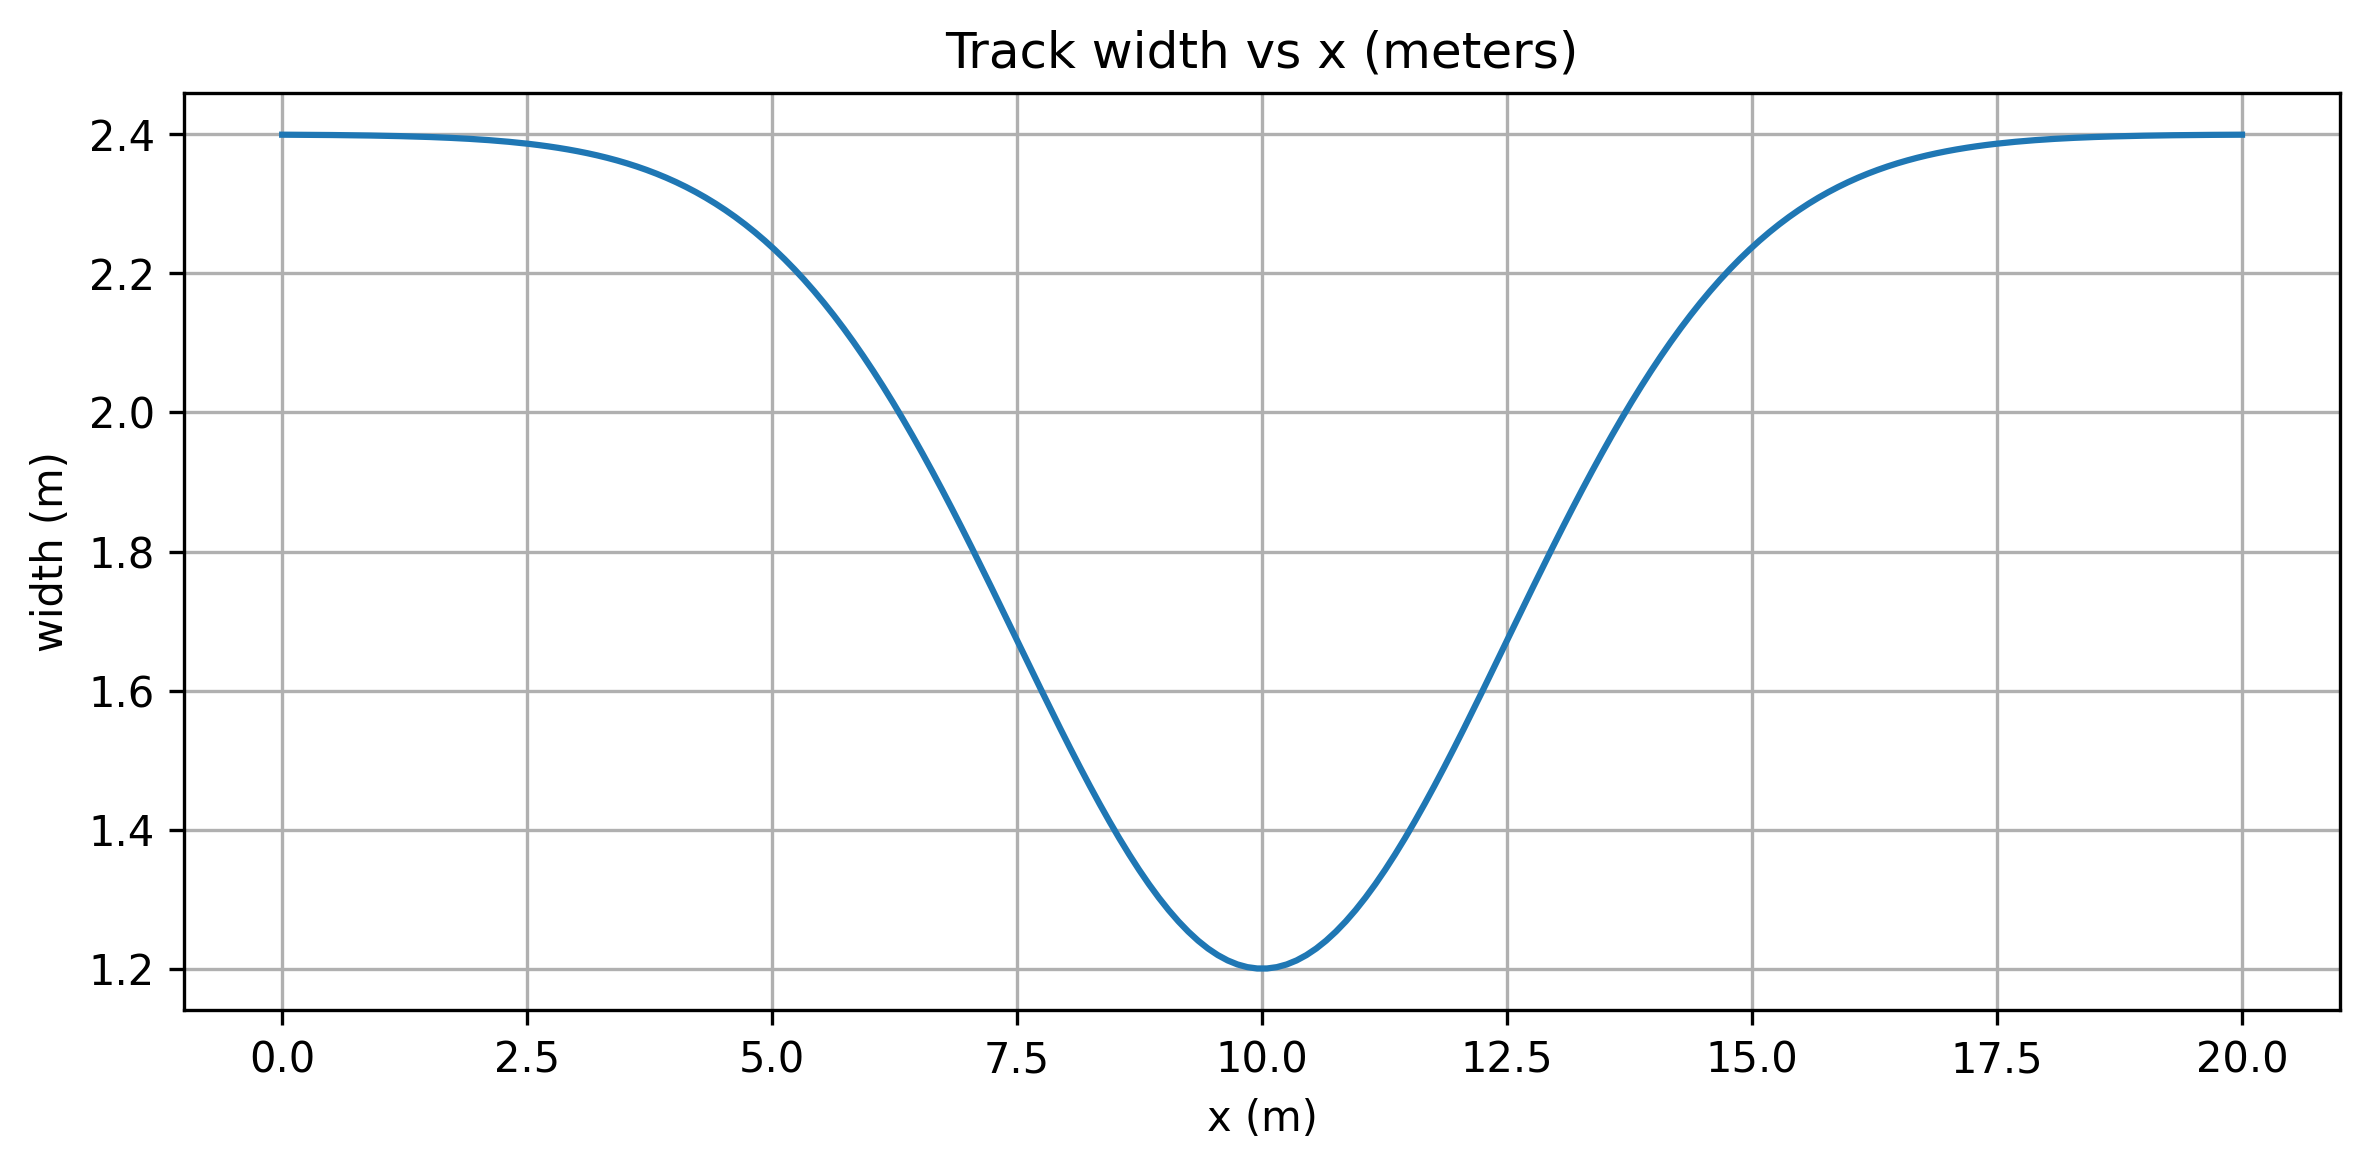

In [15]:
# @title Cell 3: Environment: straight corridor whose width narrows in the middle.
# This is intentionally simple but captures the "narrowing region" that requires faster reaction.

TRACK_LENGTH = 20.0  # meters
TRACK_HALF_WIDTH_BASE = 1.2  # meters (half width at ends)
NARROW_CENTER = TRACK_LENGTH / 2.0
NARROW_DEPTH = 0.6     # how much narrower at the center (meters)
NARROW_SIGMA = 2.5     # controls how quickly it narrows

def track_half_width(x):
    """Return half-width of track at longitudinal coordinate x (meters)."""
    # Smooth Gaussian-shaped narrowing at center:
    narrowing = NARROW_DEPTH * math.exp(-((x - NARROW_CENTER)**2) / (2 * NARROW_SIGMA**2))
    return TRACK_HALF_WIDTH_BASE - narrowing

def inside_track(x, y):
    """True if point (x,y) lies inside corridor boundaries [0, TRACK_LENGTH]."""
    if x < 0 or x > TRACK_LENGTH:
        return False
    return abs(y) <= track_half_width(x)

def lidar_raycast(car_x, car_y, car_theta, max_range=LIDAR_MAX_RANGE, num_rays=LIDAR_NUM_RAYS, step=0.02):
    """
    Simple raycast LiDAR: for each ray angle, step along ray until hit boundary or max_range.
    Returns distances (length num_rays) with angles from -90 deg to +90 deg relative to car heading.
    step: sampling step along ray (m), small values give better precision at modest cost.
    """
    angles = np.linspace(-math.pi/2, math.pi/2, num_rays)
    distances = np.full(num_rays, max_range, dtype=float)
    for i, a in enumerate(angles):
        ray_angle = car_theta + a
        r = 0.0
        hit = False
        while r <= max_range:
            rx = car_x + r * math.cos(ray_angle)
            ry = car_y + r * math.sin(ray_angle)
            # check collision with track boundaries
            if rx < 0 or rx > TRACK_LENGTH:
                distances[i] = r
                hit = True
                break
            if abs(ry) > track_half_width(rx):
                distances[i] = r
                hit = True
                break
            r += step
        if not hit:
            distances[i] = max_range
    return distances, angles

# Quick visual check of corridor width function (optional)
xs = np.linspace(0, TRACK_LENGTH, 200)
widths = [2*track_half_width(x) for x in xs]
plt.figure(figsize=(8,4), dpi=300) # Increased figure size and dpi
plt.plot(xs, widths)
plt.title('Track width vs x (meters)')
plt.xlabel('x (m)')
plt.ylabel('width (m)')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/track_width.png') # Save to Google Drive
plt.show()

In [4]:
# @title Cell 4: Vehicle dynamics (kinematic bicycle) and controllers.

@dataclass
class VehicleState:
    x: float
    y: float
    theta: float  # heading in radians (0 = along +x)
    v: float      # forward speed (m/s)

def integrate_kinematic_bicycle(state: VehicleState, steering: float, throttle: float, dt: float):
    """
    Integrate small step of kinematic bicycle model.
    steering: steering angle in radians (limited)
    throttle: target speed in m/s (we set speed directly for simplicity)
    dt: seconds
    """
    # Apply throttle directly (simple model)
    state.v = throttle
    # Kinematic bicycle equations
    state.x += state.v * math.cos(state.theta) * dt
    state.y += state.v * math.sin(state.theta) * dt
    # change in heading
    state.theta += (state.v / WHEELBASE) * math.tan(steering) * dt
    # keep theta normalized
    state.theta = (state.theta + math.pi) % (2*math.pi) - math.pi

# Pure pursuit controller (centerline is y=0):
def pure_pursuit_control(state: VehicleState, lookahead=1.0, speed=DEFAULT_SPEED, max_steer=0.6):
    """
    Simple pure-pursuit toward the centerline point (x + lookahead, 0).
    Returns (steer, throttle).
    """
    # target point in world coords:
    tx = state.x + lookahead
    ty = 0.0  # centerline y=0
    dx = tx - state.x
    dy = ty - state.y
    ld = math.hypot(dx, dy)
    if ld < 1e-6:
        return 0.0, speed
    # alpha = angle between heading and line to target
    angle_to_target = math.atan2(dy, dx)
    alpha = (angle_to_target - state.theta + math.pi) % (2*math.pi) - math.pi
    # pure pursuit steering law
    steer = math.atan2(2 * WHEELBASE * math.sin(alpha), lookahead)
    # clamp
    steer = max(-max_steer, min(max_steer, steer))
    return steer, speed

# Follow-the-gap controller (reactive):
def follow_the_gap_control(lidar_ranges, lidar_angles, safe_thresh=0.8, speed=DEFAULT_SPEED, max_steer=0.6):
    """
    Find the largest contiguous region of LiDAR rays above a threshold, choose its center.
    Returns (steer, throttle).
    """
    # threshold for free space (meters)
    thr = safe_thresh
    mask = lidar_ranges > thr
    # find contiguous segments of True in mask
    segments = []
    i = 0
    n = len(mask)
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]:
                j += 1
            segments.append((i, j-1))
            i = j
        else:
            i += 1
    if not segments:
        # no gap -> emergency slow
        return 0.0, 0.0
    # pick segment with largest angular width
    best = max(segments, key=lambda seg: seg[1]-seg[0])
    mid_idx = (best[0] + best[1]) // 2
    angle = lidar_angles[mid_idx]
    # steer toward that angle
    steer = angle  # in car frame already
    steer = max(-max_steer, min(max_steer, steer))
    return steer, speed


In [5]:
# @title Cell 5: Scheduler classes (TaskSpec is already defined)
import heapq

@dataclass(order=True)
class Job:
    deadline: int
    arrival: int = field(compare=False)
    task_name: str = field(compare=False)
    remaining: int = field(compare=False)   # ms remaining
    wcet: int = field(compare=False)
    period_ms: int = field(compare=False)
    instance_id: int = field(compare=False)
    started: bool = field(default=False, compare=False)
    start_time: int = field(default=None, compare=False)
    end_time: int = field(default=None, compare=False)
    sensor_snapshot: dict = field(default=None, compare=False)

class EDFScheduler:
    def __init__(self, task_specs, mode='LOW'):
        self.task_specs_by_name = {t.name: t for t in task_specs}
        self.mode = mode  # 'LOW' or 'HIGH'
        # initialize next release times as 0 for all tasks
        self.next_release = {}
        for t in task_specs:
            self.next_release[t.name] = 0
        # ready queue as a heap keyed by deadline
        self.ready_heap = []  # heap of (deadline, job)
        self.running_job: Job | None = None
        self.job_counters = defaultdict(int)
        # record executed job spans for plotting
        self.executed_spans = []  # list of (task_name, start_ms, end_ms)
        # track mode switch request flag (applied at next idle instant)
        self.mode_switch_requested = False
        self.mode_to_apply = None

    def current_period(self, task_name):
        spec = self.task_specs_by_name[task_name]
        return spec.T_lo if self.mode == 'LOW' else spec.T_hi

    def current_deadline(self, task_name):
        # choose D equal to period (as in the paper)
        return self.current_period(task_name)

    def release_jobs_if_due(self, current_time_ms):
        """Release jobs whose next_release == current_time_ms."""
        for name, t_spec in self.task_specs_by_name.items():
            nr = self.next_release[name]
            # next_release can be None if dropped; we keep numeric times only.
            if nr is None:
                continue
            if nr == current_time_ms:
                # if in HIGH mode and the task is dropped (chi==0), skip
                if self.mode == 'HIGH' and t_spec.chi == 0:
                    # schedule no new release and set next_release None
                    self.next_release[name] = None
                    continue
                # compute deadline relative to current time (D = period)
                period = t_spec.T_lo if self.mode == 'LOW' else t_spec.T_hi or t_spec.T_lo
                deadline = current_time_ms + int(period)
                self.job_counters[name] += 1
                job = Job(deadline=deadline,
                          arrival=current_time_ms,
                          task_name=name,
                          remaining=t_spec.C,
                          wcet=t_spec.C,
                          period_ms=period,
                          instance_id=self.job_counters[name])
                # push into ready heap keyed by deadline
                heapq.heappush(self.ready_heap, job)
                # compute next release by adding current period
                self.next_release[name] = current_time_ms + period

    def request_mode_switch(self, new_mode):
        """Request a mode change (will be applied at next idle instant)."""
        if new_mode == self.mode:
            return
        self.mode_switch_requested = True
        self.mode_to_apply = new_mode

    def apply_mode_switch_now(self, current_time_ms):
        """Apply the requested mode switch *immediately* (called when scheduler is idle)."""
        if not self.mode_switch_requested:
            return
        target = self.mode_to_apply
        print(f"[Scheduler] Applying mode switch {self.mode} -> {target} at t={current_time_ms}ms")
        self.mode = target
        # Recompute next_release times: align future releases to start at current_time + new period
        for name, t_spec in self.task_specs_by_name.items():
            if self.mode == 'HIGH' and t_spec.chi == 0:
                # dropped in high mode
                self.next_release[name] = None
            else:
                new_period = t_spec.T_lo if self.mode == 'LOW' else (t_spec.T_hi or t_spec.T_lo)
                # next release aligned at current_time + new_period
                self.next_release[name] = current_time_ms + new_period
        self.mode_switch_requested = False
        self.mode_to_apply = None

    def schedule_next(self, current_time_ms, sensor_sampler):
        """
        Choose next job to run and handle preemption. 'sensor_sampler' is a function
        that will be called when a job begins its execution (to snapshot sensors).
        """
        # if there is a running job but a ready job has earlier deadline -> preempt
        if self.ready_heap:
            top_job = self.ready_heap[0]  # smallest deadline due to dataclass ordering
            if self.running_job is None:
                # start top_job
                job = heapq.heappop(self.ready_heap)
                job.start_time = current_time_ms
                job.started = True
                # snapshot sensors at job *start*
                job.sensor_snapshot = sensor_sampler()
                self.running_job = job
            else:
                # compare deadlines
                if top_job.deadline < self.running_job.deadline:
                    # preempt
                    # push running job back to heap (with updated remaining)
                    self.running_job.start_time = self.running_job.start_time or current_time_ms
                    heapq.heappush(self.ready_heap, self.running_job)
                    job = heapq.heappop(self.ready_heap)
                    job.start_time = current_time_ms
                    job.started = True
                    job.sensor_snapshot = sensor_sampler()
                    self.running_job = job
        # if nothing ready, remain idle

    def advance_time_by(self, delta_ms, current_time_ms):
        """
        Advance running job by delta_ms (used when we leap forward).
        Return True if a job finished exactly at the end of this delta.
        """
        if self.running_job:
            dt = int(delta_ms)
            if dt >= self.running_job.remaining:
                # finishes within interval
                elapsed = self.running_job.remaining
                self.running_job.remaining = 0
                finish_time = current_time_ms + elapsed
                # record execution span
                st = self.running_job.start_time if self.running_job.start_time is not None else (finish_time - elapsed)
                self.executed_spans.append((self.running_job.task_name, st, finish_time, self.mode))
                # capture job to handle completion outside
                finished_job = self.running_job
                # set running_job to None (job finished)
                self.running_job = None
                return finished_job, finish_time
            else:
                # decrement remaining and keep it running
                self.running_job.remaining -= dt
                return None, current_time_ms + dt
        else:
            # nothing running
            return None, current_time_ms


In [6]:
# @title Cell 6: The main simulation function for a single episode.

def simulate_episode(scheduler: EDFScheduler, mode_switch_enabled=True,
                     episode_duration_ms=EPISODE_DURATION_MS,
                     physics_dt_ms=PHYSICS_DT_MS,
                     initial_state: VehicleState | None=None,
                     random_seed=None,
                     verbose=False):
    """
    Runs a single episode. Returns result dict with:
      - crashed: bool
      - executed_spans: list of job spans for Gantt
      - traj: list of (t_ms, x, y, mode) for plotting trajectory
      - mode_events: times when mode changed
    """
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
    # Initialize vehicle
    if initial_state is None:
        # random start: x in [0, TRACK_LENGTH/4], small lateral offset and heading noise
        sx = random.uniform(0.0, TRACK_LENGTH * 0.2)
        sy = random.uniform(-0.1, 0.1)
        stheta = random.uniform(-0.05, 0.05)
        sv = DEFAULT_SPEED
        state = VehicleState(sx, sy, stheta, sv)
    else:
        state = copy.deepcopy(initial_state)
    # current control (steer, throttle) that is applied to physics between driver outputs
    current_control = (0.0, DEFAULT_SPEED)
    # mode event log
    mode_log = [(0, scheduler.mode)]
    # vehicle trajectory recording
    traj = []
    # crash flag
    crashed = False

    # define the sensor sampler (called when a job actually begins execution)
    def sensor_sampler_closure():
        dists, angles = lidar_raycast(state.x, state.y, state.theta)
        return {'lidar_ranges': dists.copy(), 'lidar_angles': angles.copy(), 'car_state': copy.deepcopy(state)}

    # Simulation time in ms (event-driven)
    t = 0
    # Ensure first releases are at time 0 (scheduler.next_release already set to 0)
    # main event loop uses event-driven leaps:
    while t < episode_duration_ms and not crashed:
        # 1) If scheduler idle (no running job and no ready jobs) and mode_switch_requested -> apply
        if scheduler.mode_switch_requested and scheduler.running_job is None and len(scheduler.ready_heap) == 0 and mode_switch_enabled:
            scheduler.apply_mode_switch_now(current_time_ms=t)
            mode_log.append((t, scheduler.mode))

        # 2) Determine next release time among tasks
        future_release_times = [rt for rt in scheduler.next_release.values() if rt is not None and rt >= t]
        next_release_time = min(future_release_times) if future_release_times else None

        # 3) compute finish time of running job if any
        if scheduler.running_job:
            finish_time = t + scheduler.running_job.remaining
        else:
            finish_time = None

        # 4) decide next event time:
        candidate_times = []
        if next_release_time is not None:
            candidate_times.append(next_release_time)
        if finish_time is not None:
            candidate_times.append(finish_time)
        if candidate_times:
            next_event = min(candidate_times)
        else:
            # No future events (no releases ever): stop
            break

        # But to ensure physics gets integrated in reasonable steps, we will limit leaps to at most
        # physics_dt_ms so we can record continuous trajectory regularly for plotting
        max_leap = physics_dt_ms
        if next_event - t > max_leap:
            next_event = t + max_leap

        # Advance physics from t -> next_event using small substeps if needed
        delta = next_event - t
        # integrate in steps of physics_dt_ms
        remaining = delta
        while remaining > 0 and not crashed:
            step = min(remaining, physics_dt_ms)
            dt_s = ms2s(step)
            integrate_kinematic_bicycle(state, current_control[0], current_control[1], dt_s)
            # record traj sample
            traj.append((t, state.x, state.y, scheduler.mode))
            # collision check
            if not inside_track(state.x, state.y) or state.x < 0 or state.x > TRACK_LENGTH:
                crashed = True
                if verbose:
                    print(f"Crash detected at t={t} ms, pos=({state.x:.2f},{state.y:.2f})")
                break
            t += step
            remaining -= step

        if crashed:
            break

        # After physics integration, set t to next_event (already updated inside loop)
        # Now handle events that occur at time t (releases or job finishes)
        # Release jobs at exact t if any
        scheduler.release_jobs_if_due(current_time_ms=t)

        # If running job finishes exactly at t (note: advance_time_by is used when we jump to finish)
        if finish_time is not None and finish_time == t and scheduler.running_job:
            # we expect running job.remaining == 0
            finished_job, finish_time_check = scheduler.advance_time_by(0, current_time_ms=t)
            # if a job finished earlier logic in advance_time_by would have returned finished_job
            # but in this branch we are at finish_time exactly, so we can consider it finished
            # However, the job might have remaining > 0 if we produced partial steps above, so handle safe:
            if finished_job is None:
                # It means the running job still has remaining (not finishing right now)
                pass
            else:
                # completed job: handle side effects (control output)
                if finished_job.task_name == 'Driver':
                    # at job completion we must apply the controller output computed using the job.sensor_snapshot
                    snap = finished_job.sensor_snapshot
                    # decide which controller to use:
                    # safety check: predicted centerline too close?
                    # simple: if corridor width at lookahead future x < 0.5 -> mark unsafe
                    lookahead_x = snap['car_state'].x + 1.0
                    if lookahead_x > TRACK_LENGTH:
                        lookahead_x = TRACK_LENGTH
                    safe_margin = track_half_width(lookahead_x)
                    # if centerline is too close to boundary, use mode switch; we already set flag earlier, but driver also selects controllers
                    # check if predicted path intersects obstacles (use lidar)
                    if np.min(snap['lidar_ranges']) < 0.5:
                        # fallback to follow-the-gap
                        steer, throttle = follow_the_gap_control(snap['lidar_ranges'], snap['lidar_angles'])
                    else:
                        steer, throttle = pure_pursuit_control(snap['car_state'])
                    current_control = (steer, throttle)
                # other tasks produce no controller effect here
                # continue

        # If running job was scheduled to finish at next_event earlier than we advanced by physics steps, we need to advance job progress
        # For simplicity: compute delta since last time we advanced job and call advance_time_by to reduce remaining time accordingly.
        # We'll compute how much CPU time we have passed since the last job start: this is tricky in event-based sim, so instead:
        # After release and before scheduling next, pick job to run if any and let scheduler manage remaining times by moving to next events.
        # Schedule next runnable job (this will snapshot sensors upon starting)
        scheduler.schedule_next(current_time_ms=t, sensor_sampler=sensor_sampler_closure)

        # Edge: if we are at a finish_time event, try to finish work by advancing time by zero to capture completion
        # If the running job has remaining <= 0, advance_time_by will pop it.
        if scheduler.running_job and scheduler.running_job.remaining <= 0:
            finished_job, finish_time_check = scheduler.advance_time_by(0, current_time_ms=t)
            # handle driver finish as above
            if finished_job and finished_job.task_name == 'Driver':
                snap = finished_job.sensor_snapshot
                if np.min(snap['lidar_ranges']) < 0.5:
                    steer, throttle = follow_the_gap_control(snap['lidar_ranges'], snap['lidar_angles'])
                else:
                    steer, throttle = pure_pursuit_control(snap['car_state'])
                current_control = (steer, throttle)

        # After schedule selection, check runtime: if there is running job then compute next event again in outer loop
        # Also, allow the driving task's safety check to request mode switch based on predicted centerline proximity:
        # We evaluate safety using current LiDAR (state-based) — if min range is below 0.5m or predicted centerline width < 0.5m, request HIGH.
        # This check is done continuously at each event time:
        dists, angs = lidar_raycast(state.x, state.y, state.theta)
        min_dist = np.min(dists)
        # if danger detected -> request mode change
        if mode_switch_enabled and (min_dist < 0.5):
            scheduler.request_mode_switch('HIGH')

        # Mode can also be requested to go back to LOW if safe for some time; for simplicity, we'll request go-back when min_dist > 0.8
        if mode_switch_enabled and scheduler.mode == 'HIGH' and min_dist > 0.9:
            scheduler.request_mode_switch('LOW')

    # at loop end, collect results
    return {
        'crashed': crashed,
        'executed_spans': scheduler.executed_spans,
        'traj': traj,
        'mode_log': mode_log,
        'final_state': state,
    }


Mounted at /content/drive
Crashed? False
Number of executed job spans: 0


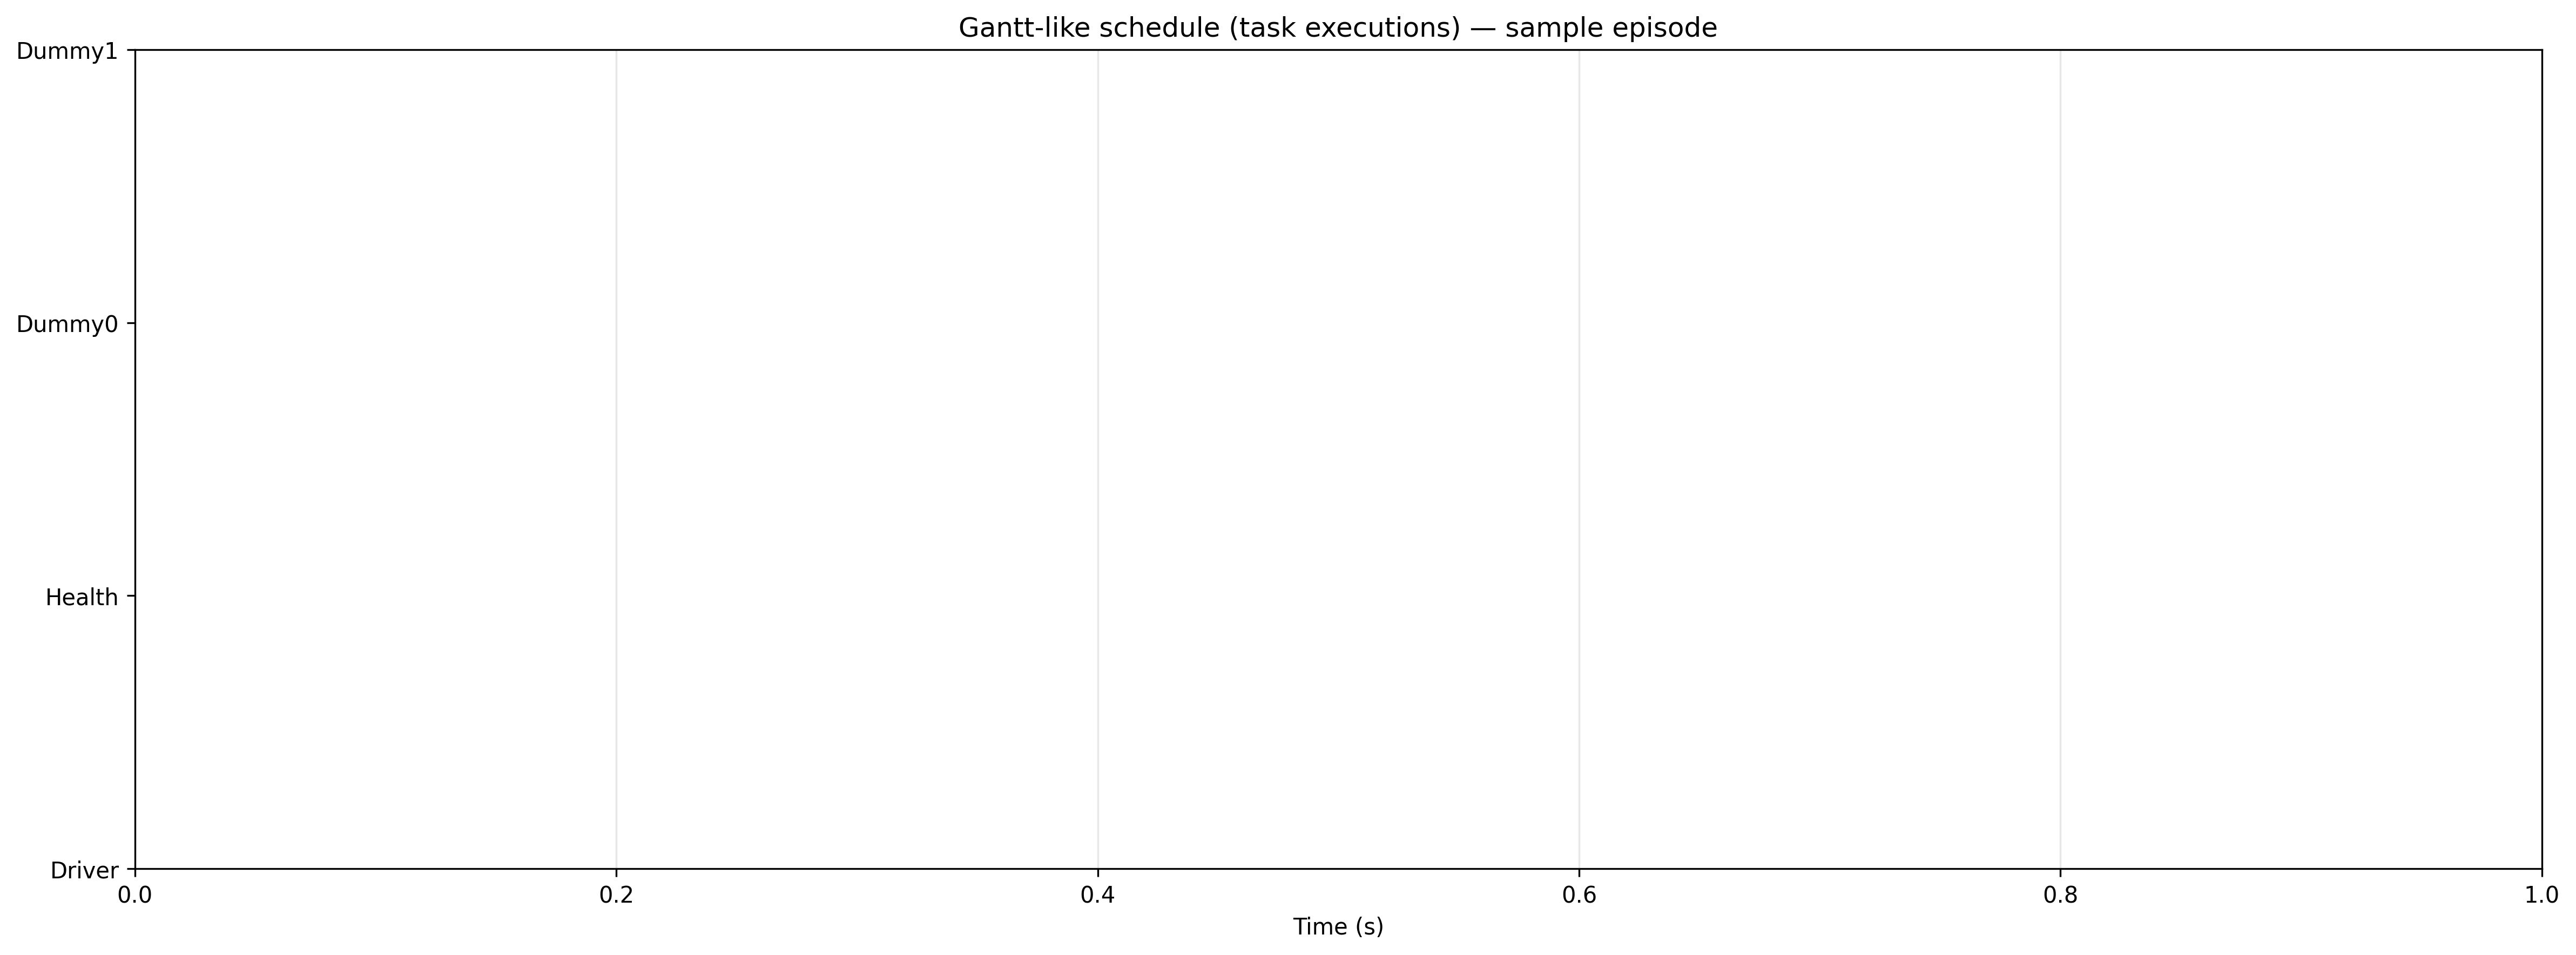

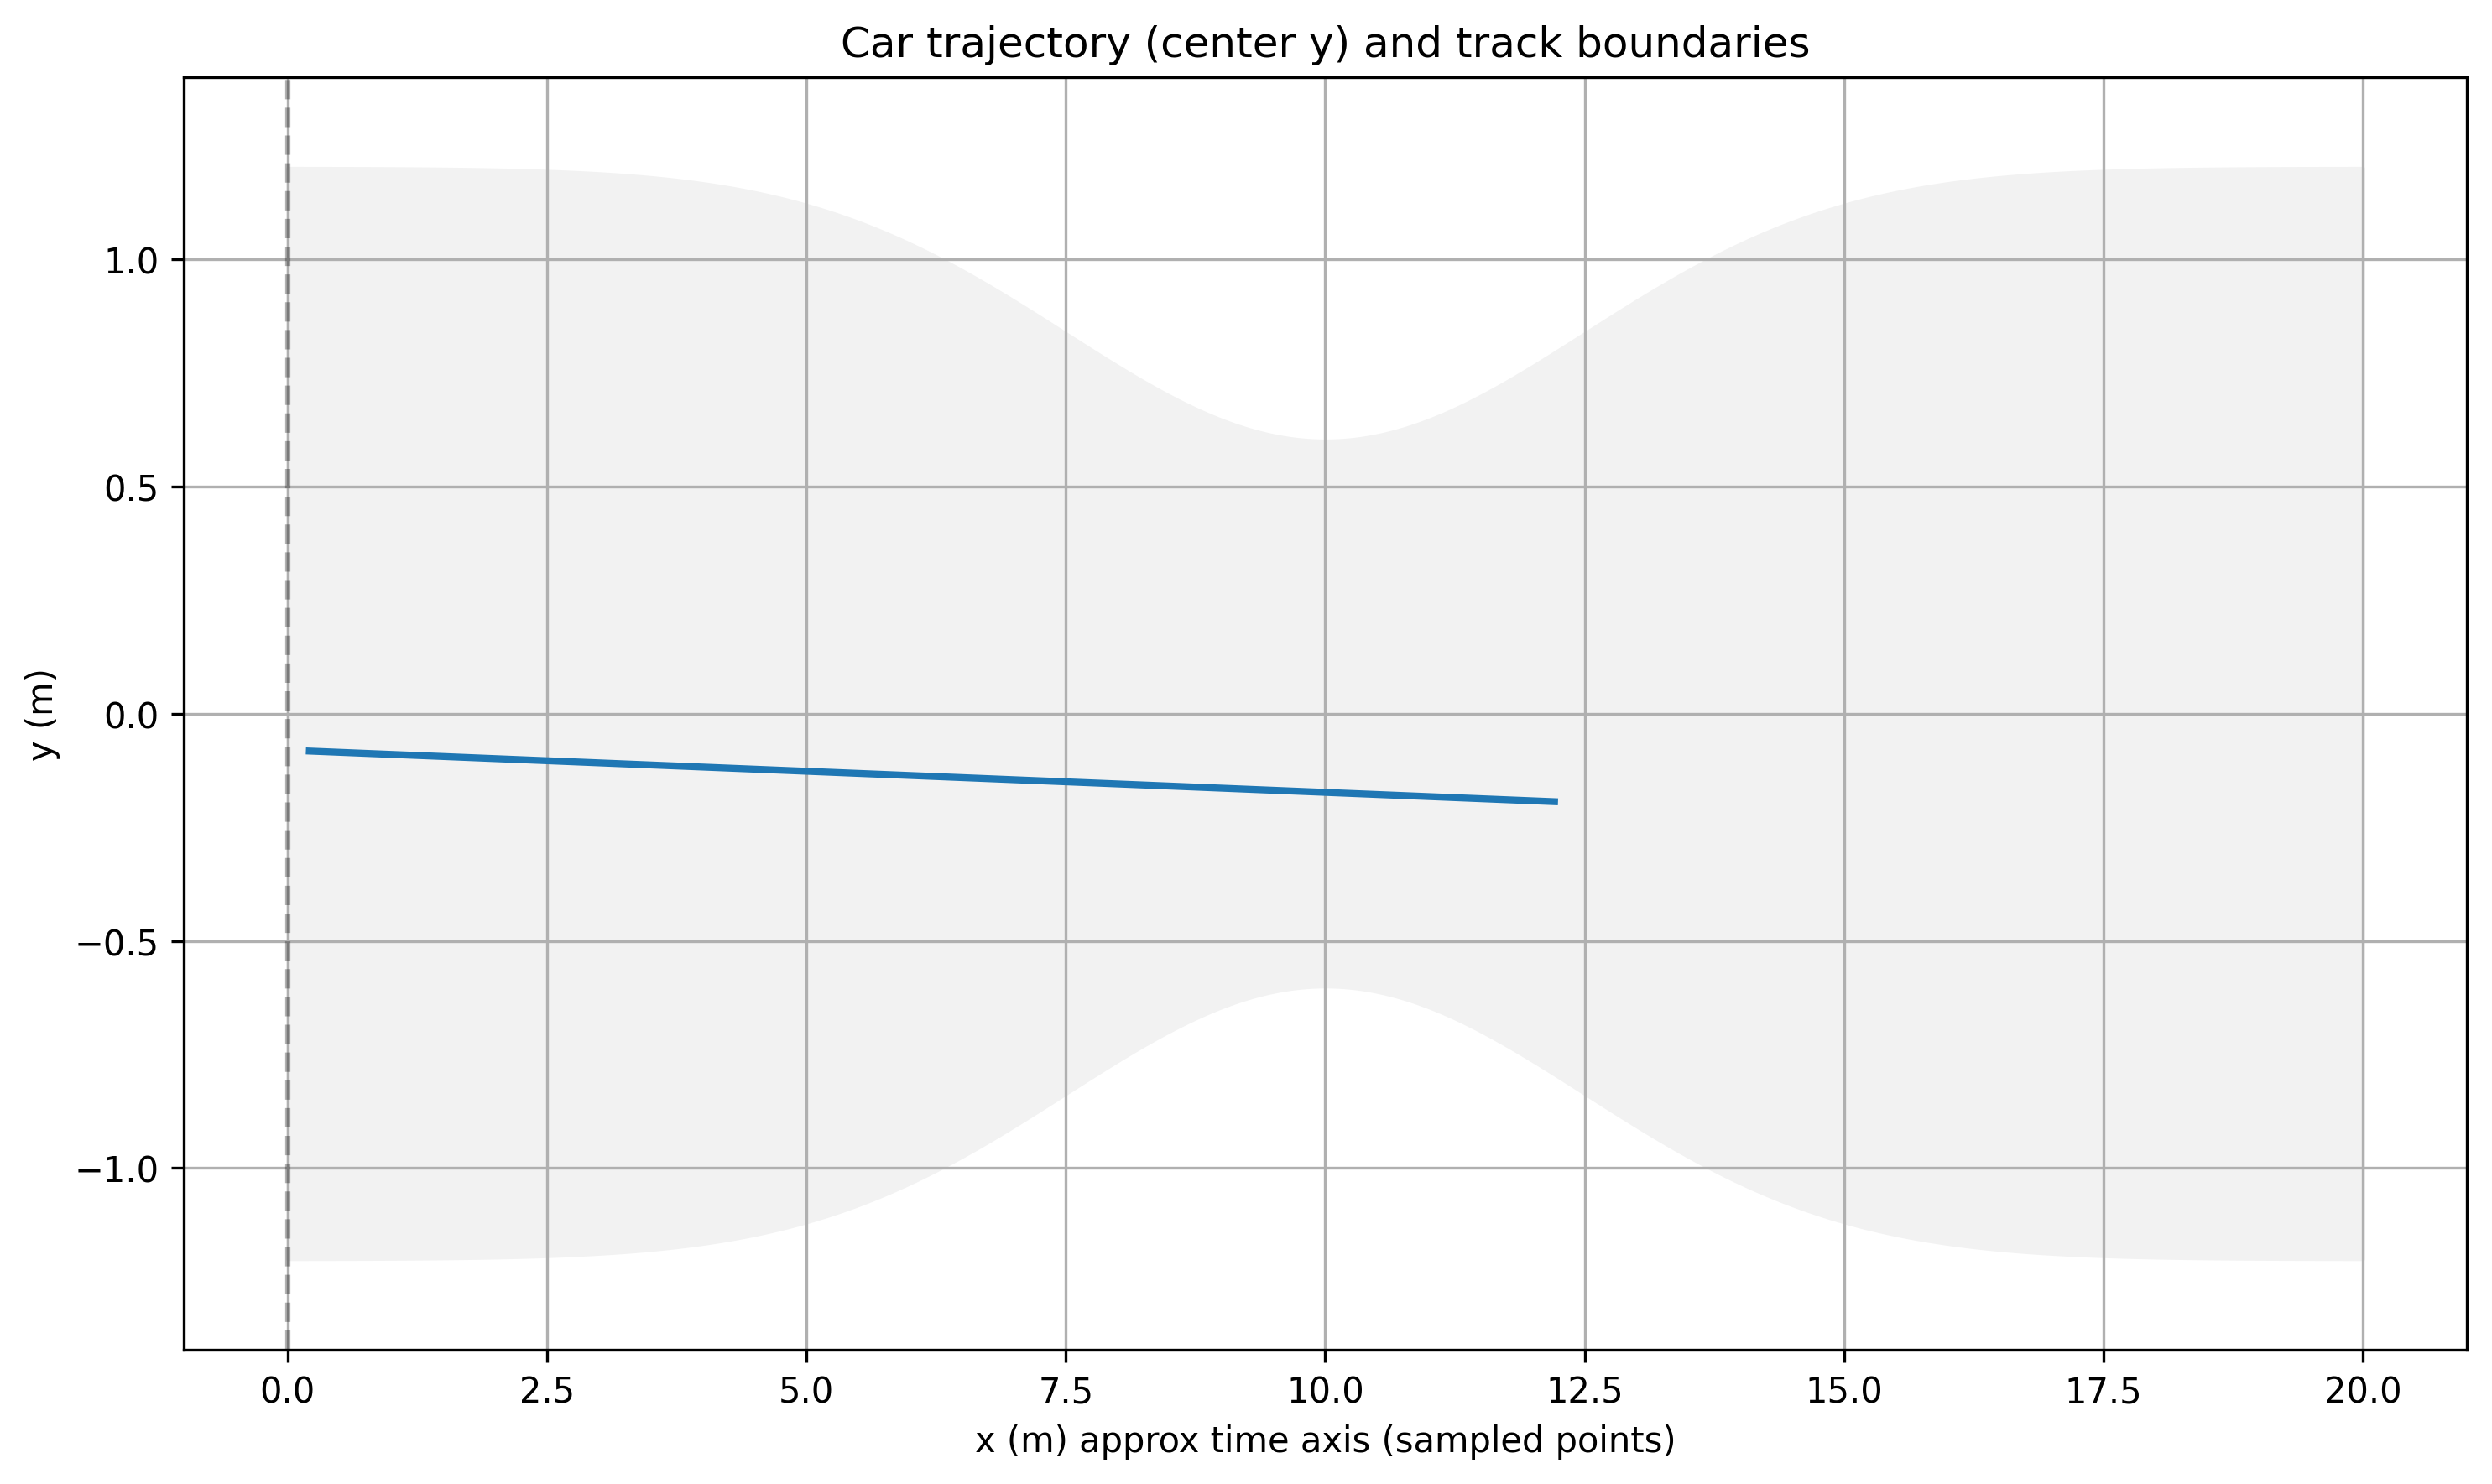

In [12]:
# @title Cell 7: Run a single episode (with mode switching enabled) and visualize scheduling & trajectory.
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Prepare scheduler and run
sched = EDFScheduler(TASK_SPECS, mode='LOW')
result = simulate_episode(sched, mode_switch_enabled=True, episode_duration_ms=10_000, random_seed=123, verbose=False)

print("Crashed?", result['crashed'])
print("Number of executed job spans:", len(result['executed_spans']))
# Create a simple Gantt chart
spans = result['executed_spans']
# aggregate spans by task for plotting levels
task_to_y = {name: i for i, name in enumerate([t.name for t in TASK_SPECS])}
fig, ax = plt.subplots(figsize=(16, 6), dpi=300) # Increased figure size and dpi
for task_name, start, end, mode in spans:
    y = task_to_y[task_name]
    ax.barh(y, end-start, left=start/1000.0, height=0.6, color=TASK_COLORS.get(task_name,'gray'), alpha=0.9)
# format
yticks = list(task_to_y.keys())
ax.set_yticks(list(task_to_y.values()))
ax.set_yticklabels(yticks)
ax.set_xlabel('Time (s)')
ax.set_title('Gantt-like schedule (task executions) — sample episode')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/gantt_schedule.png') # Save to Google Drive
plt.show()

# Trajectory plot
traj = result['traj']
times = [t for (t, x, y, m) in traj]
xs = [x for (t, x, y, m) in traj]
ys = [y for (t, x, y, m) in traj]
modes = [m for (t, x, y, m) in traj]

plt.figure(figsize=(10, 6), dpi=300) # Increased figure size and dpi
# plot corridor boundaries
xs_line = np.linspace(0, TRACK_LENGTH, 400)
upper = [track_half_width(x) for x in xs_line]
lower = [-track_half_width(x) for x in xs_line]
plt.fill_between(xs_line, lower, upper, color='#f2f2f2')
plt.plot(xs, ys, label='car path', linewidth=2)
# mark mode switch moments
mode_changes = result['mode_log']
for tm, md in mode_changes:
    plt.axvline(x=ms2s(tm), color='k', linestyle='--', alpha=0.3)
plt.xlabel('x (m) approx time axis (sampled points)')
plt.ylabel('y (m)')
plt.title('Car trajectory (center y) and track boundaries')
plt.ylim(-TRACK_HALF_WIDTH_BASE-0.2, TRACK_HALF_WIDTH_BASE+0.2)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/car_trajectory.png') # Save to Google Drive
plt.show()

In [ ]:
# @title Test 1:

In [10]:
# Cell 8: Monte Carlo trials to estimate crash probability with and without mode switching.
# Warning: can take time if N large. Default N=200 is a trade-off; reduce if you want speed.

def run_trials(N=50, episode_ms=20_0, physics_dt_ms=PHYSICS_DT_MS):
    results = {'with_switch': [], 'without_switch': []}
    for cond in ['with_switch', 'without_switch']:
        print(f"Running condition: {cond}")
        crashes = 0
        for i in range(N):
            sched = EDFScheduler(TASK_SPECS, mode='LOW')
            res = simulate_episode(sched,
                                   mode_switch_enabled=(cond=='with_switch'),
                                   episode_duration_ms=episode_ms,
                                   physics_dt_ms=physics_dt_ms,
                                   random_seed=SEED + i)
            if res['crashed']:
                crashes += 1
            # print progress every 25
            if (i+1) % 25 == 0:
                print(f"  {i+1}/{N}...")
        crash_prob = crashes / N
        results[cond] = {'crashes': crashes, 'N': N, 'p': crash_prob}
        print(f"  -> {crashes}/{N} crashed (p={crash_prob:.3f})")
    return results

# Run with smaller N first for a quick run
mc_results = run_trials(N=80, episode_ms=10_0)
mc_results


Running condition: with_switch
  25/80...
  50/80...
  75/80...
  -> 0/80 crashed (p=0.000)
Running condition: without_switch
  25/80...
  50/80...
  75/80...
  -> 0/80 crashed (p=0.000)


{'with_switch': {'crashes': 0, 'N': 80, 'p': 0.0},
 'without_switch': {'crashes': 0, 'N': 80, 'p': 0.0}}

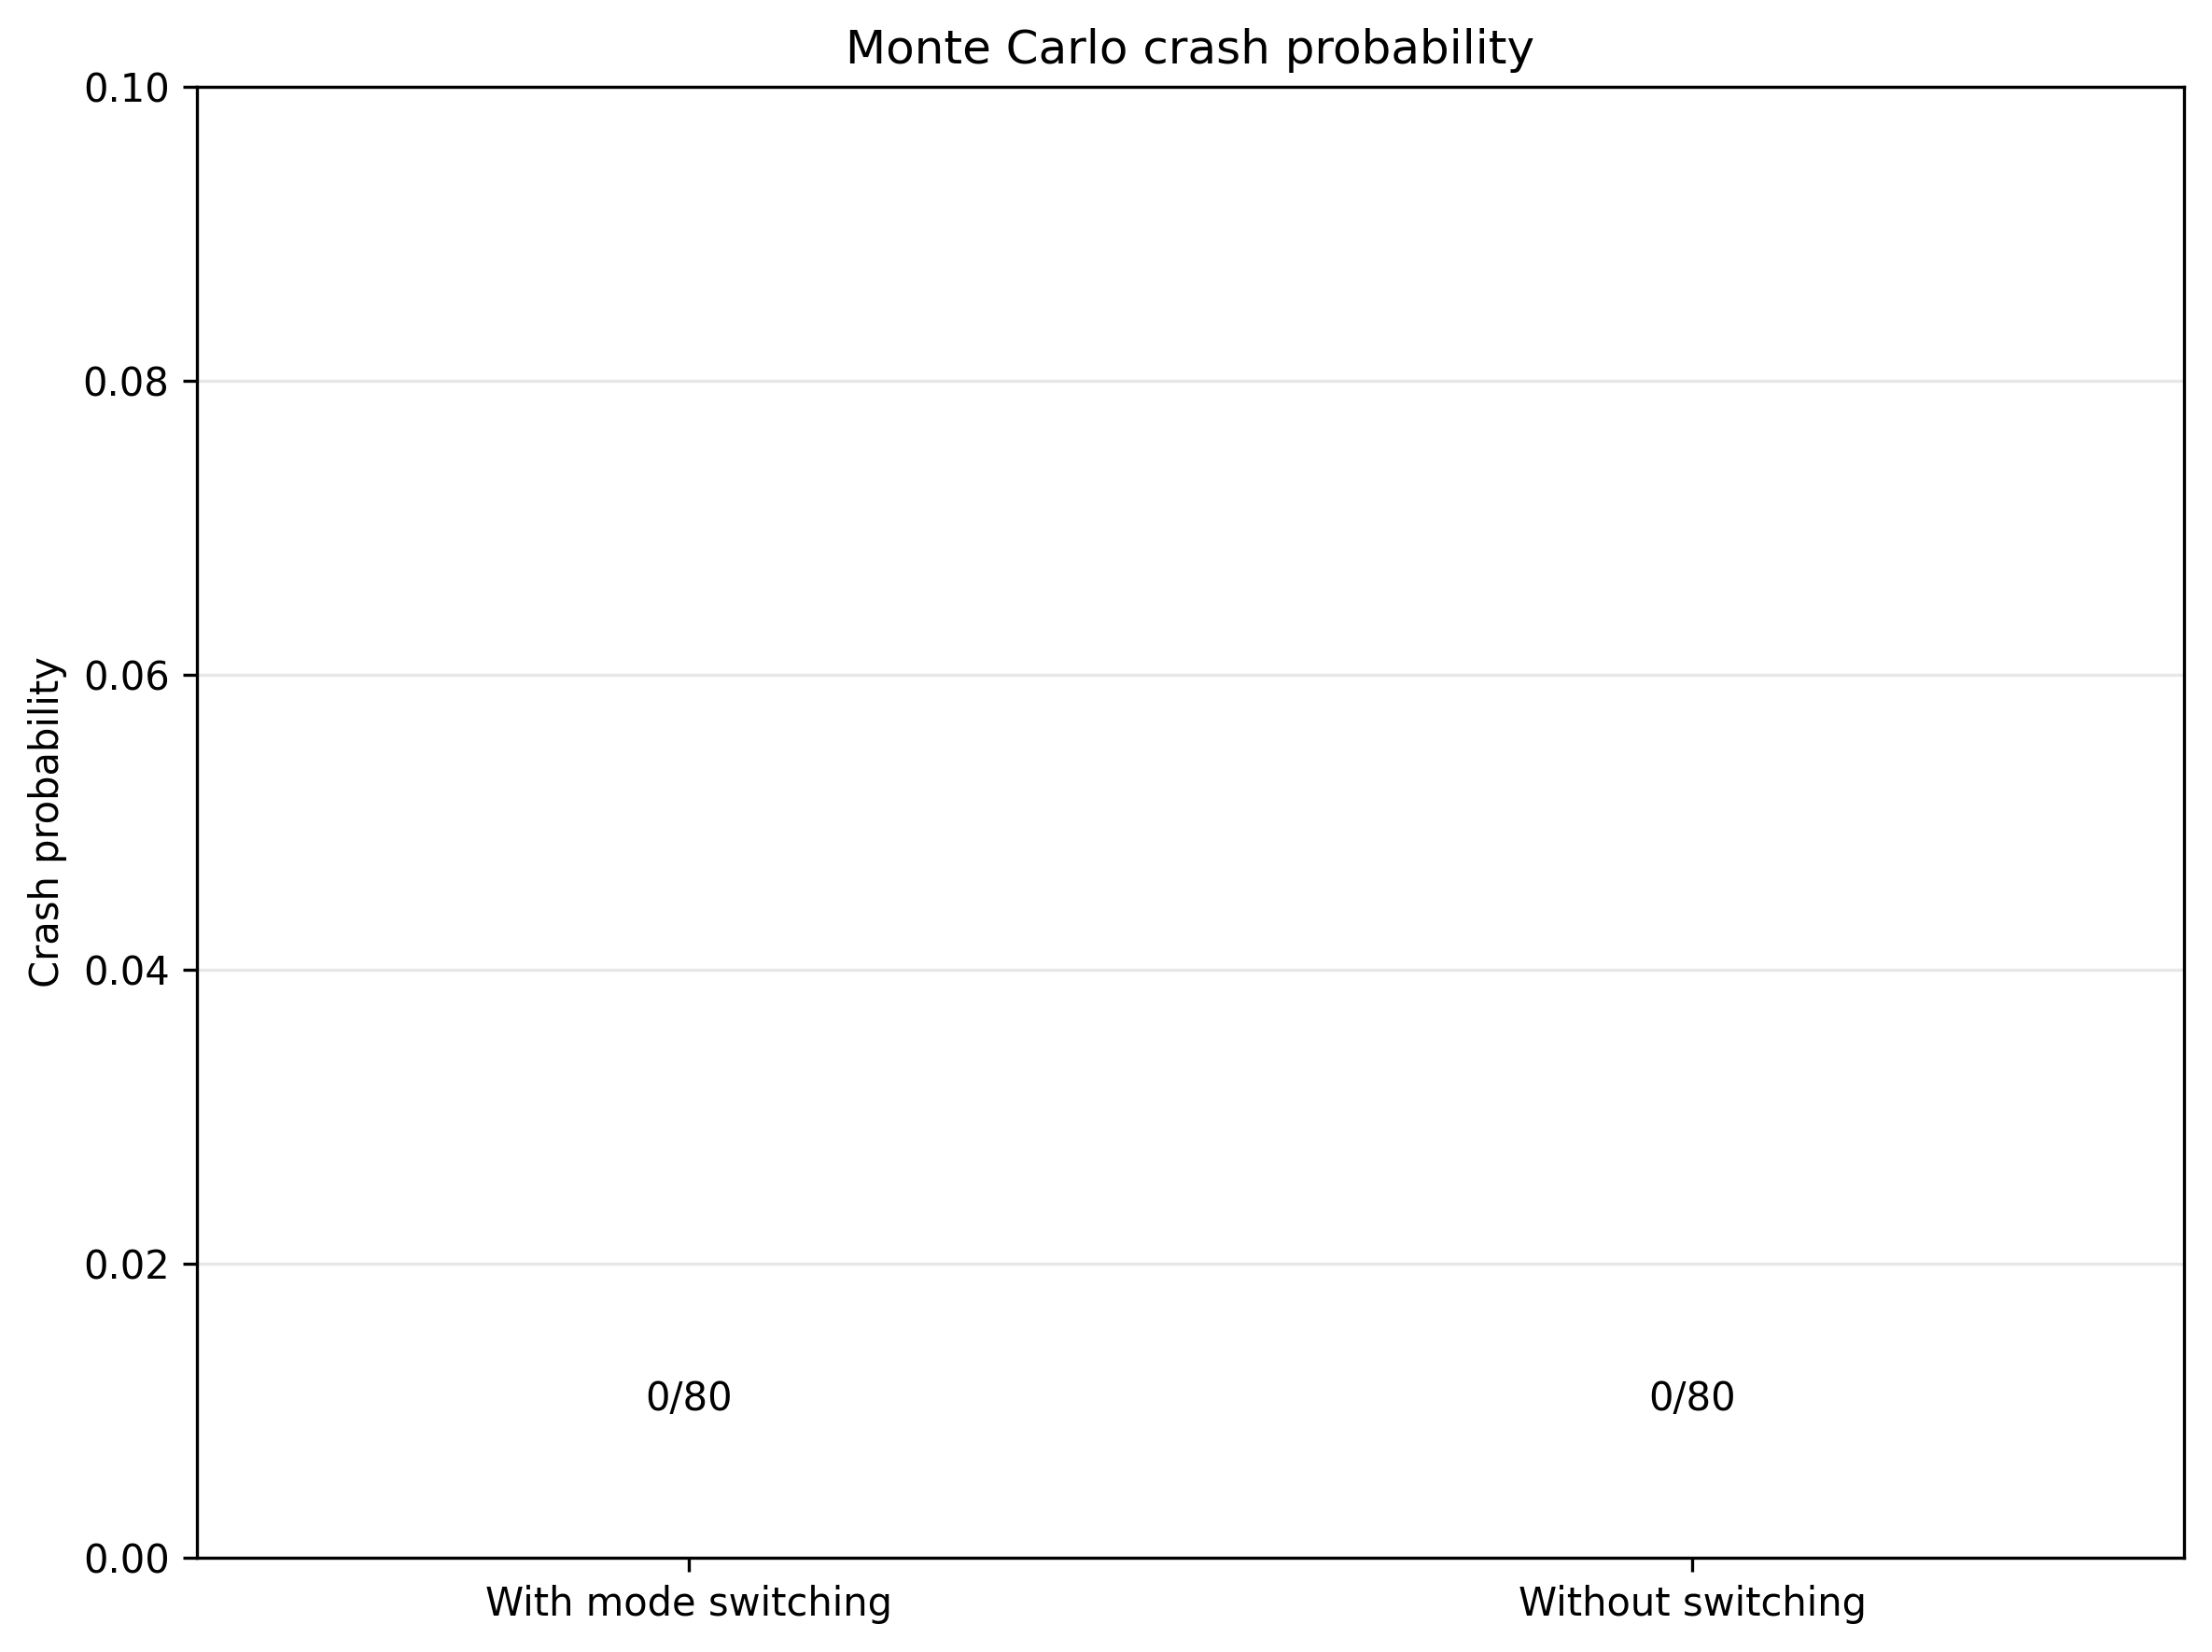

In [14]:
# @title Cell 9: Plot Monte Carlo results
from google.colab import drive
import os # Import the os module

# Mount Google Drive (if not already mounted)
if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

conds = ['with_switch', 'without_switch']
ps = [mc_results[c]['p'] for c in conds]
Ns = [mc_results[c]['N'] for c in conds]
plt.figure(figsize=(8, 6), dpi=300) # Increased figure size and dpi
plt.bar([0,1], ps, color=['#2ca02c','#d62728'])
plt.xticks([0,1], ['With mode switching', 'Without switching'])
plt.ylabel('Crash probability')
for i, (p, n) in enumerate(zip(ps, Ns)):
    plt.text(i, p + 0.01, f'{mc_results[conds[i]]["crashes"]}/{n}', ha='center')
plt.ylim(0, max(ps)*1.6 if max(ps)>0 else 0.1)
plt.title('Monte Carlo crash probability')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/monte_carlo_crash_probability.png') # Save to Google Drive
plt.show()

In [ ]:
# @title Test 2:

In [19]:
# Cell 8: Monte Carlo trials to estimate crash probability with and without mode switching.
# Warning: can take time if N large. Default N=200 is a trade-off, reduce if you want speed.

def run_trials(N=50, episode_ms=20_000, physics_dt_ms=PHYSICS_DT_MS):
    results = {'with_switch': [], 'without_switch': []}
    for cond in ['with_switch', 'without_switch']:
        print(f"Running condition: {cond}")
        crashes = 0
        for i in range(N):
            sched = EDFScheduler(TASK_SPECS, mode='LOW')
            res = simulate_episode(sched,
                                   mode_switch_enabled=(cond=='with_switch'),
                                   episode_duration_ms=episode_ms,
                                   physics_dt_ms=physics_dt_ms,
                                   random_seed=SEED + i)
            if res['crashed']:
                crashes += 1
            # print progress every 25
            if (i+1) % 25 == 0:
                print(f"  {i+1}/{N}...")
        crash_prob = crashes / N
        results[cond] = {'crashes': crashes, 'N': N, 'p': crash_prob}
        print(f"  -> {crashes}/{N} crashed (p={crash_prob:.3f})")
    return results

# Run with smaller N first for a quick run
mc_results = run_trials(N=20, episode_ms=2_000) # Further reduced N and episode_ms for faster execution
mc_results

Running condition: with_switch
  -> 0/20 crashed (p=0.000)
Running condition: without_switch
  -> 0/20 crashed (p=0.000)


{'with_switch': {'crashes': 0, 'N': 20, 'p': 0.0},
 'without_switch': {'crashes': 0, 'N': 20, 'p': 0.0}}

In [ ]:
# @title Final Test Results:

In [22]:
import matplotlib.pyplot as plt
import os # Import os for Google Drive check

def run_trials(N=50, episode_ms=10_000, physics_dt_ms=PHYSICS_DT_MS):
    """
    Run Monte Carlo trials to estimate crash probability with and without mode switching.
    Automatically prints progress and generates a bar chart at the end.
    """
    results = {'with_switch': [], 'without_switch': []}
    summary = {}

    for cond in ['with_switch', 'without_switch']:
        print(f"\nRunning condition: {cond}")
        crashes = 0
        for i in range(N):
            sched = EDFScheduler(TASK_SPECS, mode='LOW')
            res = simulate_episode(sched,
                                   mode_switch_enabled=(cond == 'with_switch'),
                                   episode_duration_ms=episode_ms,
                                   physics_dt_ms=physics_dt_ms,
                                   random_seed=SEED + i)
            if res['crashed']:
                crashes += 1

            # Progress update
            if (i + 1) % max(1, N // 4) == 0:
                print(f"  {i+1}/{N} episodes complete...")

        crash_prob = crashes / N
        summary[cond] = {'crashes': crashes, 'N': N, 'p': crash_prob}
        print(f"  -> {crashes}/{N} crashed (p={crash_prob:.3f})")

    # --- Visualization: crash probabilities ---
    labels = ["With Switch", "Without Switch"]
    probs = [summary['with_switch']['p'], summary['without_switch']['p']] # Corrected line to extract probabilities

    plt.figure(figsize=(8, 6), dpi=300)
    plt.bar(labels, probs, color=['#2ca02c','#d62728'])
    plt.ylabel('Crash probability')
    for i, (p, n) in enumerate(zip(probs, [summary['with_switch']['N'], summary['without_switch']['N']])): # Adjusted N extraction
        plt.text(i, p + 0.01, f'{summary[labels[i].replace(" ", "_").lower()]["crashes"]}/{n}', ha='center') # Adjusted crash count extraction
    plt.ylim(0, max(probs)*1.6 if max(probs)>0 else 0.1)
    plt.title('Monte Carlo crash probability')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # Mount Google Drive (if not already mounted) and save
    if not os.path.isdir('/content/drive'):
      from google.colab import drive
      drive.mount('/content/drive')
    plt.savefig('/content/drive/MyDrive/monte_carlo_crash_probability_from_func.png') # Save to Google Drive
    plt.show()

    return summary # Return the summary dictionary


Running condition: with_switch
  5/20 episodes complete...
  10/20 episodes complete...
  15/20 episodes complete...
  20/20 episodes complete...
  -> 0/20 crashed (p=0.000)

Running condition: without_switch
  5/20 episodes complete...
  10/20 episodes complete...
  15/20 episodes complete...
  20/20 episodes complete...
  -> 0/20 crashed (p=0.000)


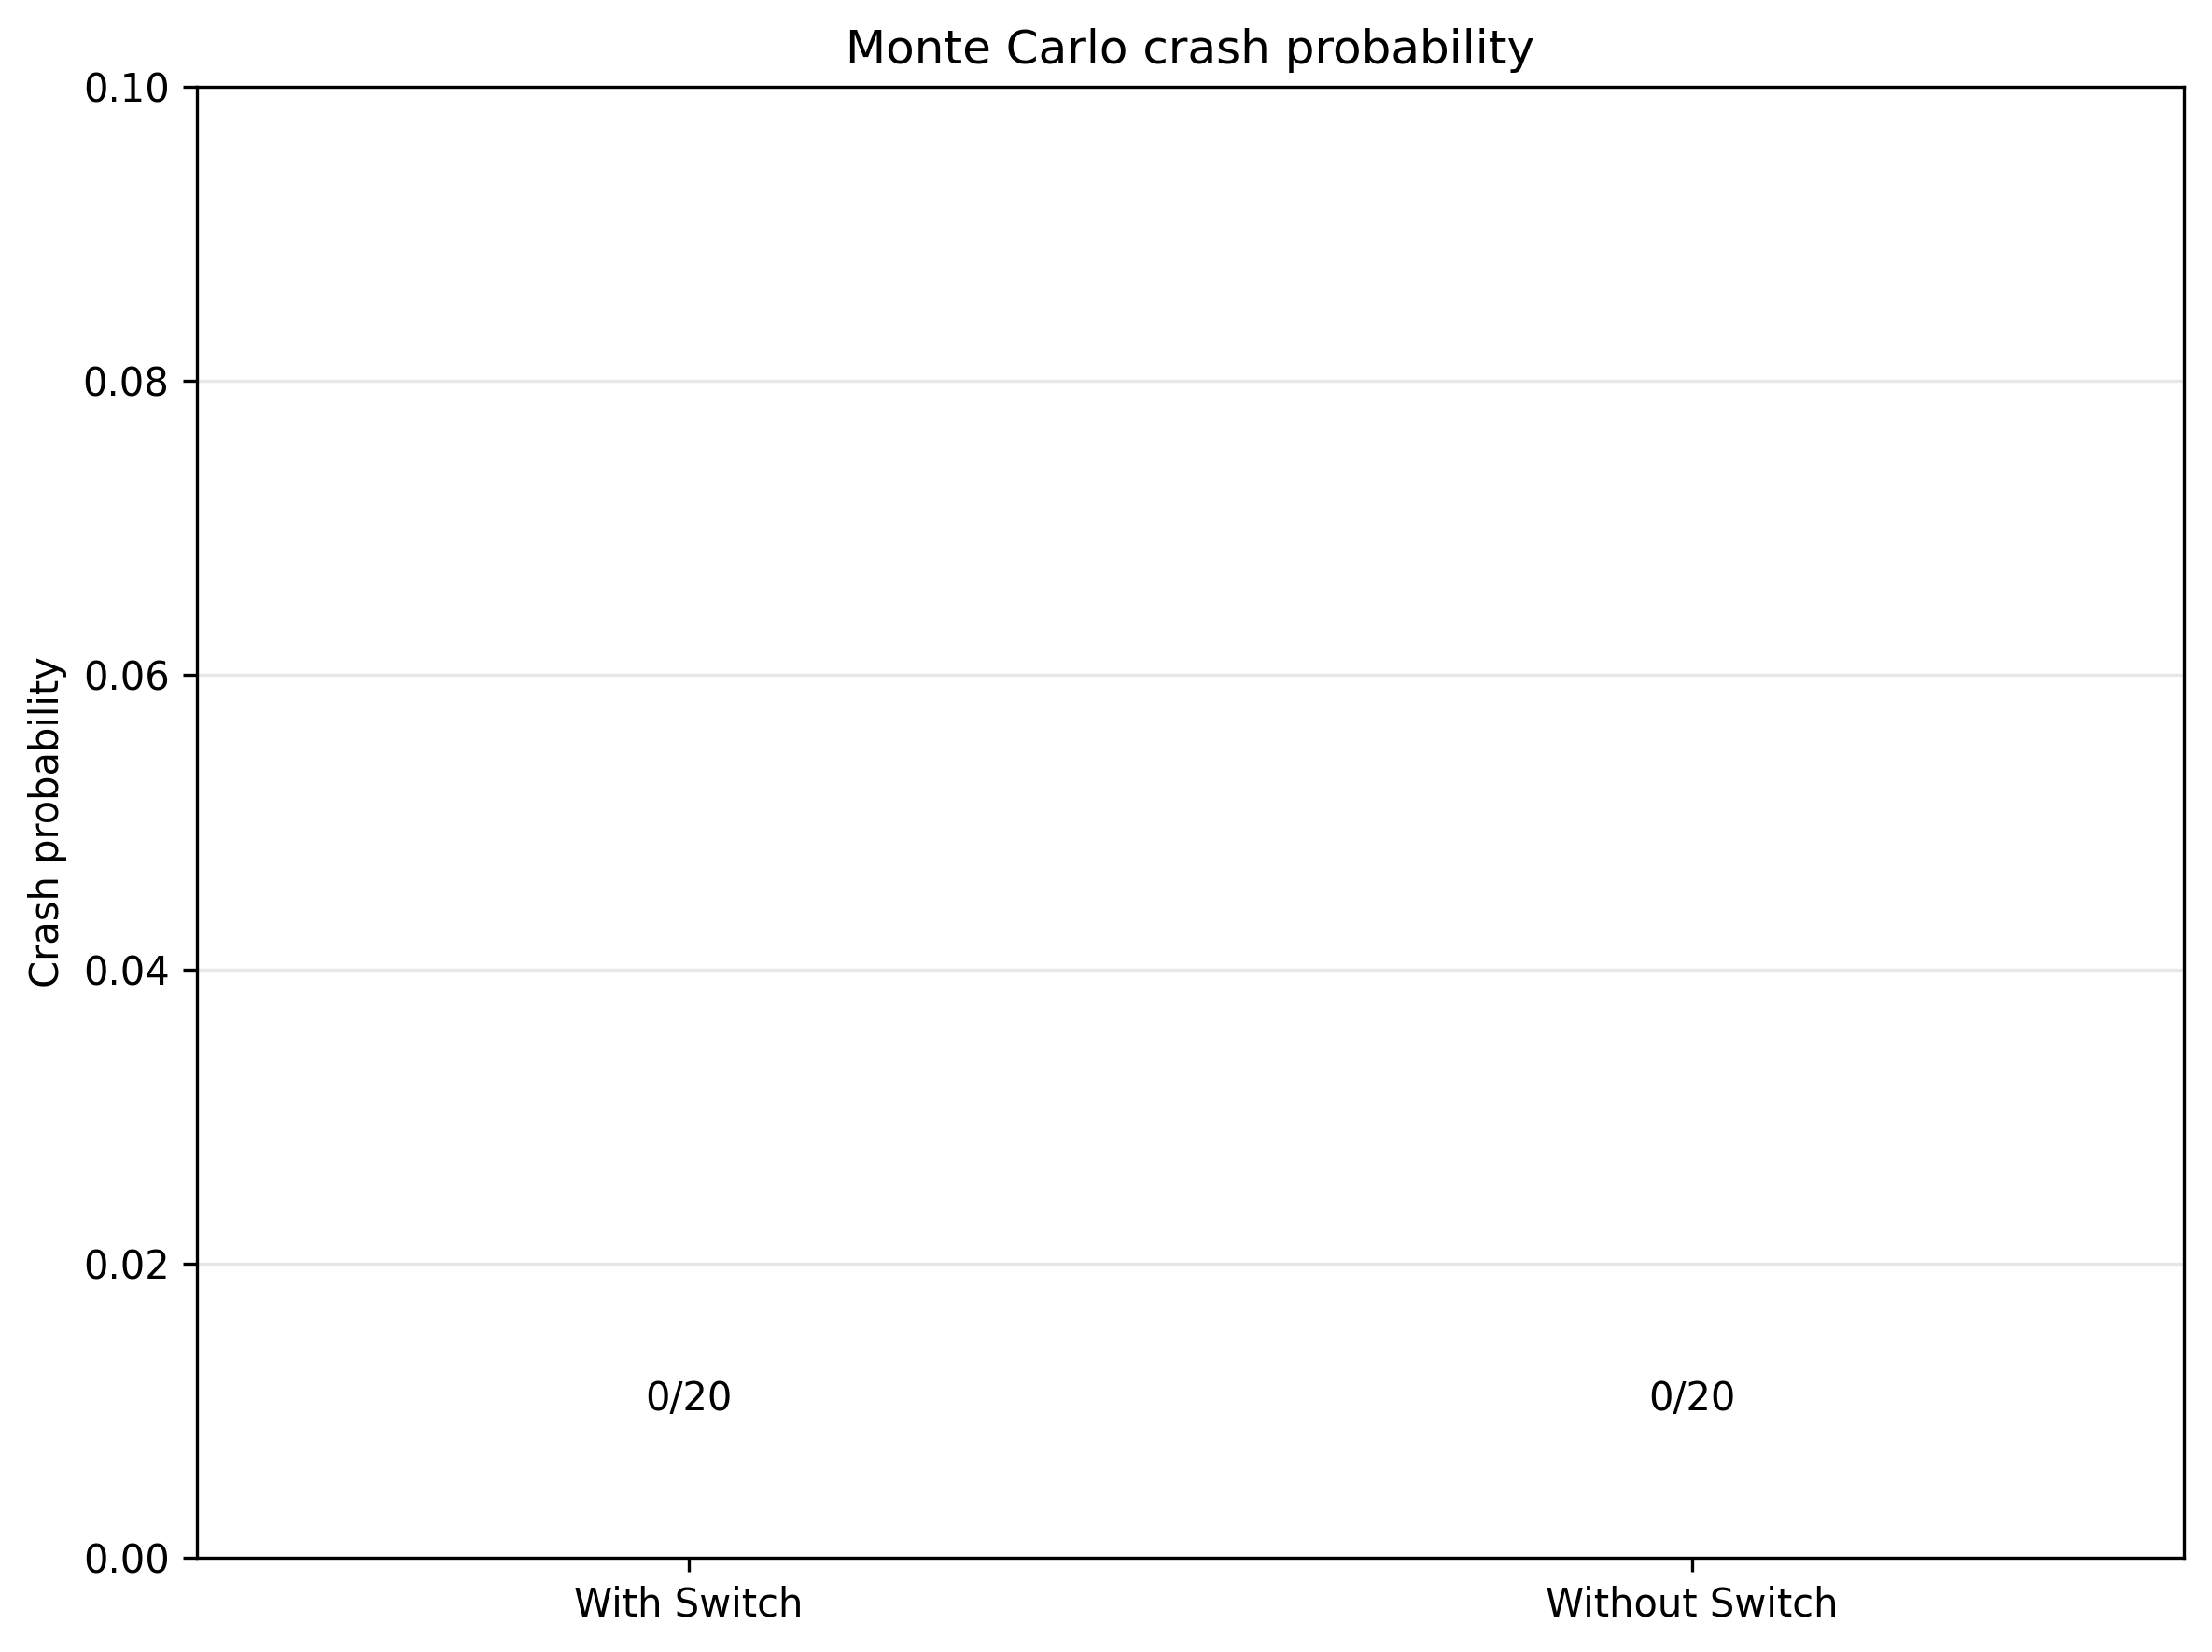

In [23]:
# @title Quick run
results = run_trials(N=20, episode_ms=10_000)

# More robust statistics
# results = run_trials(N=80, episode_ms=20_000)


### Summary of Important Results

In [24]:
print("--- Important Results ---")
print("\nMonte Carlo Crash Probability Results:")
for cond in mc_results:
    print(f"  {cond}: {mc_results[cond]['crashes']}/{mc_results[cond]['N']} crashes (probability: {mc_results[cond]['p']:.3f})")

# You can add other important results here as you identify them
# Example: Print if the single episode simulation crashed
print("\nSingle Episode Simulation Result:")
print(f"  Crashed: {result['crashed']}")
print(f"  Number of executed job spans: {len(result['executed_spans'])}")

--- Important Results ---

Monte Carlo Crash Probability Results:
  with_switch: 0/20 crashes (probability: 0.000)
  without_switch: 0/20 crashes (probability: 0.000)

Single Episode Simulation Result:
  Crashed: False
  Number of executed job spans: 0
